# Bitflipping with DQN and Hindsight Experience Replay (HER)

### Packages

In [1]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
import pandas as pd                # rolling average plot
import progressbar as pb           # tracking time while training

from Bitflipping_Environment import BitFlippingEnv
from dqn_agent import Agent

### Testing Environment

In [2]:
def test_bitflipping(n_bits, n_episodes=5, policy=None, render=False):
    """ Test bitflipping environment, optionally with agent as policy and rendering (printing).

    @param n_bits: number of bits
    @param n_episodes: number of episodes to test
    @param policy: agent to act according to current policy
    @param render: print states of environment
    @return: average success-rate of number of episodes
    """
    env = BitFlippingEnv(n_bits)
    success = []

    for e in range(n_episodes):
        state, _, _, _ = env.reset()
        if render:
            env.render()
        for t in range(1000):

            if policy is None:
                action = np.random.randint(0, n_bits)
            else:
                state_goal = np.concatenate([state['obs'], state['goal']])
                action = policy.act(state_goal, eps=0)

            state, reward, done, info = env.step(action)
            if render:
                env.render()
            if done:
                break
        success.append(int(info))
    return np.mean(success)

In [3]:
# testing random actions in env
test_bitflipping(n_bits=5, n_episodes=3, render=True)  

Step  0    Bits: [1 1 0 0 0]   Goal: [0 1 1 0 0]   Success: False
Step  1    Bits: [1 0 0 0 0]   Goal: [0 1 1 0 0]   Success: False
Step  2    Bits: [1 0 0 1 0]   Goal: [0 1 1 0 0]   Success: False
Step  3    Bits: [1 0 1 1 0]   Goal: [0 1 1 0 0]   Success: False
Step  4    Bits: [1 0 0 1 0]   Goal: [0 1 1 0 0]   Success: False
Step  5    Bits: [0 0 0 1 0]   Goal: [0 1 1 0 0]   Success: False
######## DONE in 5 timesteps, success: False ########

Step  0    Bits: [1 0 0 1 1]   Goal: [0 0 1 1 0]   Success: False
Step  1    Bits: [0 0 0 1 1]   Goal: [0 0 1 1 0]   Success: False
Step  2    Bits: [0 0 0 0 1]   Goal: [0 0 1 1 0]   Success: False
Step  3    Bits: [0 1 0 0 1]   Goal: [0 0 1 1 0]   Success: False
Step  4    Bits: [0 1 0 1 1]   Goal: [0 0 1 1 0]   Success: False
Step  5    Bits: [0 1 0 0 1]   Goal: [0 0 1 1 0]   Success: False
######## DONE in 5 timesteps, success: False ########

Step  0    Bits: [0 1 1 1 1]   Goal: [0 0 1 0 1]   Success: False
Step  1    Bits: [0 1 1 1 0]   G

0.0

### Training Setup

In [4]:
DEFAULT_PARAMS = {
    'n_bits': 35,                 # n bits to flip in environment (n corresponding target bits)
    'seed': 0,                    # random seed for environment, torch, numpy, random packages

    'eps': 0.2,                   # probability of random action, 'epsilon-greedy' policy
    'buffer_size': int(1e6),      # replay-buffer size
    'batch_size': 64,             # mini-batch size
    'gamma': 0.98,                # discount factor
    'tau': 0.05,                  # soft update of target network, 1-tau = polyak coefficient
    'lr': 0.001,                  # learning rate

    # training setup
    # HINT: for higher number of bits, strategy 'final' works better
    'replay_strategy': 'final',   # 'none' (ignore HER), 'final','future','episode' for HER
    'n_epochs': 200,              # number of epochs, HER paper: 200 epochs (i.e. maximum of 8e6 timesteps)
    'n_cycles': 50,               # number of cycles per epoch, HER paper: 50 cycles
    'n_episodes': 16,             # number of episodes per cycle, HER paper: 16 episodes
    'n_optim': 40,                # number of optimization steps every cycle, HER paper: 40 steps
}


def set_seeds(seed: int = 0):
    """ Set random seed for all used packages (numpy, torch, random).

    @param seed: random seed to be set, default is 0.
    """
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    pass


set_seeds(DEFAULT_PARAMS['seed'])

### DQN + HER

In [5]:
def train(n_bits, agent):
    """ Train DQN agent, with option for HER.

    @param n_bits: number of bits in bitflip environment
    @param agent: DQN agent to learn
    @return: list of success from every episode
    """
    print("Training DQN on Bitflipping with", n_bits, "bits for", DEFAULT_PARAMS['n_epochs'], "epochs...")

    # widget bar to display progress during training
    widget = ['training loop: ', pb.Percentage(), ' ', pb.Bar(), ' ', pb.ETA()]
    timer = pb.ProgressBar(widgets=widget, maxval=DEFAULT_PARAMS['n_epochs']).start()

    env = BitFlippingEnv(n_bits)
    success = []
    eps = DEFAULT_PARAMS['eps']
    for i_epoch in range(1, DEFAULT_PARAMS['n_epochs'] + 1):
        for i_cycle in range(DEFAULT_PARAMS['n_cycles']):
            for i_episode in range(DEFAULT_PARAMS['n_episodes']):
                state, _, _, _ = env.reset()
                state_ep, act_ep, reward_ep, next_state_ep, done_ep = [], [], [], [], []
                for t in range(1000):
                    state_goal = np.concatenate([state['obs'], state['goal']])
                    action = agent.act(state_goal, eps)
                    next_state, reward, done, info = env.step(action)

                    # save current transition of episode
                    state_ep.append(state.copy())
                    act_ep.append(action)
                    reward_ep.append(reward)
                    next_state_ep.append(next_state.copy())
                    done_ep.append(done)

                    state = next_state
                    if done:
                        break
                success.append(int(info))
                # for standard experience replay
                agent.store_episode(state_ep, act_ep, reward_ep, next_state_ep, done_ep)
                # HER: save additional goals
                # if not info:  # use HER only if unsuccessful episode
                agent.store_episode_HER(state_ep, act_ep, next_state_ep,
                                        replay_strategy=DEFAULT_PARAMS['replay_strategy'])

            # optimize and soft update of networks
            for _ in range(DEFAULT_PARAMS['n_optim']):
                agent.learn()
            agent.soft_update(agent.qnetwork_local, agent.qnetwork_target, DEFAULT_PARAMS['tau'])

        # stop training earlier
        if np.mean(success[-100:]) > 0.98:
            print("\n learning done")
            break
            
        if i_epoch % (DEFAULT_PARAMS['n_cycles'] / 10) == 0:
            print('\rEpoch {} \t Success: {:.4f}'.format(i_epoch, np.mean(success[-50:])))
        timer.update(i_epoch)
    timer.finish()
    return success

### Start Training Agent

In [6]:
agent = Agent(DEFAULT_PARAMS['n_bits'], DEFAULT_PARAMS['n_bits'], DEFAULT_PARAMS['batch_size'],
              DEFAULT_PARAMS['buffer_size'], DEFAULT_PARAMS['gamma'], DEFAULT_PARAMS['lr'])

success = train(DEFAULT_PARAMS['n_bits'], agent)

training loop: N/A% |                                          | ETA:  --:--:--

Training DQN on Bitflipping with 35 bits for 200 epochs...


training loop:   2% |#                                         | ETA:   0:33:33

Epoch 5 	 Success: 0.0000


training loop:   5% |##                                        | ETA:   0:41:10

Epoch 10 	 Success: 0.0000


training loop:   7% |###                                       | ETA:   0:49:28

Epoch 15 	 Success: 0.0400


training loop:  10% |####                                      | ETA:   0:56:05

Epoch 20 	 Success: 0.1200


training loop:  12% |#####                                     | ETA:   0:59:48

Epoch 25 	 Success: 0.2000


training loop:  15% |######                                    | ETA:   1:01:23

Epoch 30 	 Success: 0.2200


training loop:  17% |#######                                   | ETA:   1:01:51

Epoch 35 	 Success: 0.6000


training loop:  20% |########                                  | ETA:   1:01:36

Epoch 40 	 Success: 0.6200


training loop:  22% |#########                                 | ETA:   1:00:48

Epoch 45 	 Success: 0.7600


training loop:  25% |##########                                | ETA:   0:59:47

Epoch 50 	 Success: 0.9000


training loop:  27% |###########                               | ETA:   0:58:42

Epoch 55 	 Success: 0.9600


training loop:  30% |############                              | ETA:   0:57:25

Epoch 60 	 Success: 0.9200


training loop: 100% |##########################################| Time:  0:25:33



 learning done


In [7]:
# saving trained network
torch.save(agent.qnetwork_local.state_dict(), './trained/checkpoint_' + str(DEFAULT_PARAMS['n_bits']) + 'bits.pth')

### Results

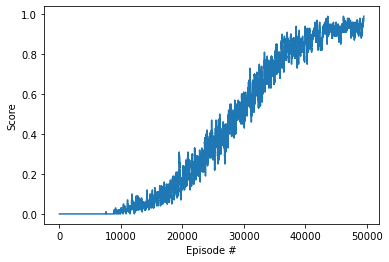

In [8]:
# Plot rolling average of success
N = 100
rolling_avg = pd.Series(success).rolling(window = N).mean().iloc[N-1:].values

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(rolling_avg)), rolling_avg)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Test trained Agent

In [9]:
n = 35
env = BitFlippingEnv(n)

# load the weights from file --------
agent = Agent(DEFAULT_PARAMS['n_bits'], DEFAULT_PARAMS['n_bits'], DEFAULT_PARAMS['batch_size'],
              DEFAULT_PARAMS['buffer_size'], DEFAULT_PARAMS['gamma'], DEFAULT_PARAMS['lr'])

agent.qnetwork_local.load_state_dict(torch.load('./trained/checkpoint_35bits.pth'))

test_bitflipping(n_bits=n, n_episodes=1, policy=agent, render=True)

Step  0    Bits: [1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1]   Goal: [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0]   Success: False
Step  1    Bits: [1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 1]   Goal: [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0]   Success: False
Step  2    Bits: [1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0]   Goal: [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0]   Success: False
Step  3    Bits: [1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0]   Goal: [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0]   Success: False
Step  4    Bits: [0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 1 0 1 1 0 1 1 0 1 0 1 0 0]   Goal: [0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0]   Success: False
Step  5    Bits: [0 1 0 0 1 0 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 0 1 1 

1.0

In [10]:
print("Testing agent for 100 episodes, success-rate: ",
          test_bitflipping(DEFAULT_PARAMS['n_bits'], n_episodes=100, policy=agent)*100, "%")

Testing agent for 100 episodes, success-rate:  100.0 %
